# Import Libraries

In [10]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

import cv2
import matplotlib.pyplot as plt

import glob
import torch
import pytesseract
import os
from craft_text_detector import Craft
import numpy as np
# from tensorflow.keras.preprocessing import image

Ultralytics YOLOv8.0.132  Python-3.8.17 torch-2.0.1 CUDA:0 (NVIDIA GeForce GTX 960M, 4096MiB)
Setup complete  (8 CPUs, 15.8 GB RAM, 185.6/238.5 GB disk)


In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C://Program Files//Tesseract-OCR//tesseract.exe'

os.environ["TESSDATA_PREFIX"] =  "C://Program Files//Tesseract-OCR//tessdata"
custom_config = r'-c preserve_interword_spaces=5 --oem 3 --psm 12'

# Load Model

In [3]:
model = YOLO('billboard_500.pt')

# Craft Module

In [4]:
class CraftModule:
    def __init__(self,craft):
        self.craft = craft
        self.boxes = None
        self.image = None
    
    def plot_image(self,img):
        plt.axis('off');
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
        plt.show();
    
    def detect_text(self,image):
        self.image = image.copy()
        self.boxes = self.craft.detect_text(self.image)['boxes']
        self.plot_image(self.image)
        print('------------ Detected Text Regions ------------')
        self.draw_rectangles()
        # print('------------ Croped Text Regions ------------')
        self.show_cropped_image()

    def get_bounding_boxes(self,box):
        flat_box = box.flatten()
        x_min = round(min([flat_box[x] for x in [0,2,4,6]]))
        y_min = round(min([flat_box[y] for y in [1,3,5,7]]))
        x_max = round(max([flat_box[x] for x in [0,2,4,6]]))
        y_max = round(max([flat_box[y] for y in [1,3,5,7]]))

        return x_min,y_min,x_max,y_max
    
    def draw_rectangles(self):
        image_rect = self.image.copy()
        for box in self.boxes:
            x_min,y_min,x_max,y_max = self.get_bounding_boxes(box)
            image_rect = cv2.rectangle(image_rect, (x_min,y_min), (x_max,y_max), (255,0,0), 2)
        self.plot_image(image_rect)
            
    def show_cropped_image(self):
        for box in self.boxes:
            x_min,y_min,x_max,y_max = self.get_bounding_boxes(box)
            roi = self.image[y_min : y_max , x_min : x_max].copy()

            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roi_final = cv2.bitwise_not(roi_gray)

            
            # self.plot_image(cv2.bitwise_not(roi_gray))
            text_english = pytesseract.image_to_string(roi_final,lang = 'eng', config = custom_config)
            text_nepali = pytesseract.image_to_string(roi_final,lang = 'nep', config = custom_config)
            text_hindi = pytesseract.image_to_string(roi_final,lang = 'hin', config = custom_config)
            text_nepali_hindi = pytesseract.image_to_string(roi_final,lang = 'nep+hin', config = custom_config)

            print(f'English : {text_english}')
            print(f'Hindi : {text_hindi}')
            print(f'Nepali and Hindi : {text_nepali_hindi}')
            print(f'Nepali : {text_nepali}')

            # self.plot_image(roi)
    

In [6]:
class CraftModule:
    def __init__(self,craft_detector,craft_extractor):
        self.craft_extractor = craft_extractor
        self.craft_detector = craft_detector
        self.boxes = None
        self.image = None
        self.file = None
    
    def plot_image(self,img):
        plt.axis('off');
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
        plt.show();

    def rotate_image(self):
        img = self.image.copy()
        image = img.copy()
        boxes = self.craft_detector.detect_text(img)['boxes']
        angled_boxes = []

        # Get angled boxes
        for box in boxes:
            if len(box) >= 3:  # Ensure at least 3 points for a polygon
                # Convert box points to numpy array for easier manipulation
                box_points = np.array(box, dtype=np.int32).reshape(-1, 2)

                # Calculate the minimum bounding rectangle
                rotated_rect = cv2.minAreaRect(box_points)
                box_vertices = cv2.boxPoints(rotated_rect)
                box_vertices = np.int0(box_vertices)
                angled_boxes.append(box_vertices)
                cv2.drawContours(img, [box_vertices], 0, (255, 0, 0), 2)
        # plt.imshow(img)

        try:
            # Get largest contour and rotate on basis of that
            largest_contour = max(angled_boxes, key=cv2.contourArea)
            rows,cols = img.shape[:2]
            [vx,vy,x,y] = cv2.fitLine(largest_contour, cv2.DIST_L2,0,0.01,0.01)
            lefty = (-x*vy/vx) + y
            righty = ((cols-x)*vy/vx)+y

            angle_rad = np.arctan2(vy, vx)
            angle = np.degrees(angle_rad)[0]

            height, width = img.shape[:2]
            center = (width // 2, height // 2)
            
            if angle != 90:
                rotation_matrix = cv2.getRotationMatrix2D(center, angle , scale=1.0)
                self.image = cv2.warpAffine(self.image, rotation_matrix , (width, height))   
        except:
            pass

    def detect_text(self,image,file_name):
        self.file = file_name
        self.image = image
        cv2.imwrite(f'results/{self.file}_0.jpg',image)

        # self.plot_image(image)
        self.rotate_image()
        self.boxes = self.craft_extractor.detect_text(self.image)['boxes']
        # self.plot_image(self.image)
        # print('------------ Detected Text Regions ------------')
        # self.draw_rectangles()
        # print('------------ Croped Text Regions ------------')
        self.show_cropped_image()

    def get_bounding_boxes(self,box):
        flat_box = box.flatten()
        x_min = round(min([flat_box[x] for x in [0,2,4,6]]))
        y_min = round(min([flat_box[y] for y in [1,3,5,7]]))
        x_max = round(max([flat_box[x] for x in [0,2,4,6]]))
        y_max = round(max([flat_box[y] for y in [1,3,5,7]]))

        return x_min,y_min,x_max,y_max
    
    # def draw_rectangles(self):
    #     image_rect = self.image.copy()
    #     for box in self.boxes:
    #         x_min,y_min,w,h = cv2.boundingRect(box)
    #         image_rect = cv2.rectangle(image_rect, (x_min,y_min), (x_min + w,y_min + h), (255,0,0), 2)
        # self.plot_image(image_rect)
            
    def show_cropped_image(self):
        count = 1
        for box in self.boxes:
            x_min,y_min,x_max,y_max = self.get_bounding_boxes(box)
            roi = self.image[y_min : y_max , x_min : x_max].copy()
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roi_invert = cv2.bitwise_not(roi_gray)
            # roi_invert = cv2.resize(roi_invert, None, fx=2, fy=2)
            # thresh = cv2.threshold(roi_gray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            # edges = cv2.Canny(roi, 27, 255)
            # self.plot_image(roi_gray)
            # self.plot_image(cv2.bitwise_not(roi_gray))


            # contour, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            # print(len(contour))
            
            # text_english_t = pytesseract.image_to_string(thresh,lang = 'eng', config = custom_config)
            # text_nepali_t = pytesseract.image_to_string(thresh,lang = 'nep', config = custom_config)
            # text_nepali_hin_t = pytesseract.image_to_string(thresh,lang = 'nep+hin', config = custom_config)


            text_english = pytesseract.image_to_string(roi_invert,lang = 'eng', config = custom_config)
            text_nepali = pytesseract.image_to_string(roi_invert,lang = 'nep', config = custom_config)
            text_nepali_hin = pytesseract.image_to_string(roi_invert,lang = 'nep+hin', config = custom_config)


            # print(f'English (gray) : {text_english}')
            # print(f'Nepali (gray) : {text_nepali}')
            # print(f'Nepali + Hindi (gray) : {text_nepali_hin}')

            # print(f'English (thresh) : {text_english_t}')
            # print(f'Nepali (thresh) : {text_nepali_t}')
            # print(f'Nepali + Hindi (thresh) : {text_nepali_hin_t}')

            cv2.imwrite(f'results/{self.file}_{count}.jpg',roi)
            
            with open(f'results/{self.file}_{count}.txt', "w") as file:
                file.write(f'English : {text_english}\n')
                file.write(f'Nepali : {text_nepali}\n')
                file.write(f'Nepali + Hindi : {text_nepali_hin}\n')
            
            count += 1

            # self.plot_image(roi)
    

In [15]:
# img = cv2.imread('segmentation/manakamana.png')
# craft = Craft( crop_type="box", cuda=True,text_threshold=0.8,link_threshold=0.8,low_text=0.1)
# CraftModule(craft).detect_text(img)

In [19]:
img = cv2.imread('segmentation/manakamana.png')
craft = Craft( crop_type="box", cuda=True,text_threshold=0.5,link_threshold=0.5,low_text=0.05)
CraftModule(craft_extractor=craft,craft_detector=craft).detect_text(img,'fd.jpg')

# Plot Image

In [20]:
def plot_image(image):
    plt.axis('off');
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));
    plt.show();

# Read Image

In [8]:
def plot_image(image):
    plt.axis('off');
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));
    plt.show();

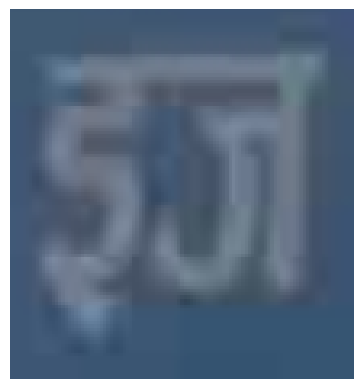

------------ Detected Text Regions ------------


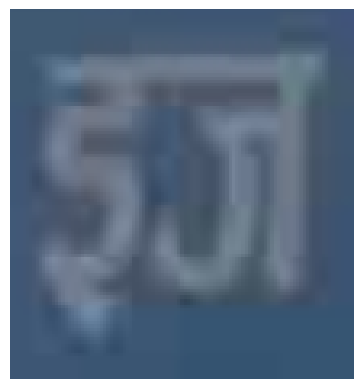

In [9]:
img = cv2.imread('segmentation/e.png')
craft = Craft( crop_type="box", cuda=True,text_threshold=0.8,link_threshold=0.3,low_text=0.3)
CraftModule(craft).detect_text(img)

# Binirization

In [10]:
img = cv2.imread('segmentation/e.png')

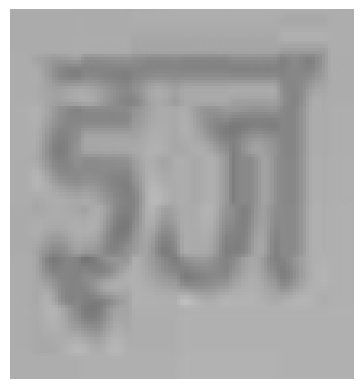

In [11]:
# img = image.img_to_array(img, dtype='uint8')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
roi_invert = cv2.bitwise_not(img_gray)
# imgf = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,23,4)
# dst = cv2.fastNlMeansDenoisingColored(imgf, None, 10, 10, 7, 15) 
plot_image(roi_invert)


In [12]:
text_nepali = pytesseract.image_to_alto_xml(roi_invert,lang = 'hin', config = custom_config)
text_nepali

b'<?xml version="1.0" encoding="UTF-8"?>\n<alto xmlns="http://www.loc.gov/standards/alto/ns-v3#" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.loc.gov/standards/alto/ns-v3# http://www.loc.gov/alto/v3/alto-3-0.xsd">\n\t<Description>\n\t\t<MeasurementUnit>pixel</MeasurementUnit>\n\t\t<sourceImageInformation>\n\t\t\t<fileName>C:\\Users\\Ghost\\AppData\\Local\\Temp\\tess_yend8hv1_input.PNG</fileName>\n\t\t</sourceImageInformation>\n\t\t<OCRProcessing ID="OCR_0">\n\t\t\t<ocrProcessingStep>\n\t\t\t\t<processingSoftware>\n\t\t\t\t\t<softwareName>tesseract v5.3.1.20230401</softwareName>\n\t\t\t\t</processingSoftware>\n\t\t\t</ocrProcessingStep>\n\t\t</OCRProcessing>\n\t</Description>\n\t<Layout>\n\t\t<Page WIDTH="107" HEIGHT="115" PHYSICAL_IMG_NR="0" ID="page_0">\n\t\t\t<PrintSpace HPOS="0" VPOS="0" WIDTH="107" HEIGHT="115">\n\t\t\t\t<ComposedBlock ID="cblock_0" HPOS="9" VPOS="13" WIDTH="89" HEIGHT="89">\n\t\t\t\

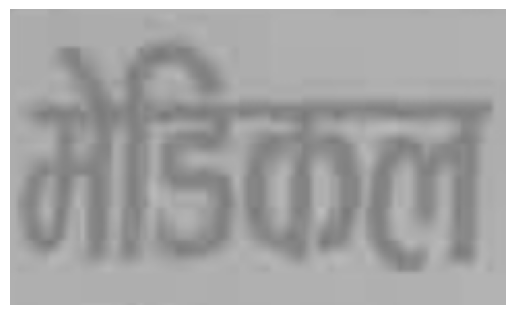

'मेडिकल\n'

In [13]:
img = cv2.imread('segmentation/med.png')
# img = image.img_to_array(img, dtype='uint8')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
roi_invert = cv2.bitwise_not(img_gray)
# imgf = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,23,4)
# dst = cv2.fastNlMeansDenoisingColored(imgf, None, 10, 10, 7, 15) 
plot_image(roi_invert)
text_nepali = pytesseract.image_to_string(roi_invert,lang = 'hin', config = custom_config)
text_nepali

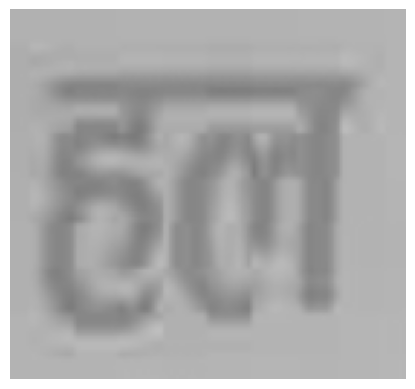

'हल\n'

In [14]:
img = cv2.imread('segmentation/hall.png')
# img = image.img_to_array(img, dtype='uint8')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
roi_invert = cv2.bitwise_not(img_gray)
# imgf = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,23,4)
# dst = cv2.fastNlMeansDenoisingColored(imgf, None, 10, 10, 7, 15) 
plot_image(roi_invert)
text_nepali = pytesseract.image_to_string(roi_invert,lang = 'hin+nep', config = custom_config)
text_nepali

In [15]:
def rotate_image(image,angle):
    
    # Get the height and width of the image
    height, width = image.shape[:2]
    
    # Define the rotation angle (e.g., 90 degrees clockwise)
    angle = angle
    
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    
    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    
    return rotated_image

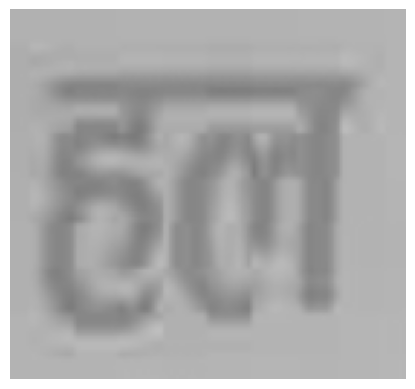

'हल\n'

In [16]:
img = cv2.imread('segmentation/mana.png')
img = rotate_image(img,2)
# img = image.img_to_array(img, dtype='uint8')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# roi_invert = cv2.bitwise_not(img_gray)
# imgf = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,23,4)
# dst = cv2.fastNlMeansDenoisingColored(imgf, None, 10, 10, 7, 15) 
plot_image(roi_invert)
text_nepali = pytesseract.image_to_string(roi_invert,lang = 'hin', config = custom_config)
text_nepali

In [17]:
pytesseract.pytesseract.tesseract_cmd = r'C://Program Files//Tesseract-OCR//tesseract.exe'

os.environ["TESSDATA_PREFIX"] =  "C://Program Files//Tesseract-OCR//tessdata"
custom_config = r'-c preserve_interword_spaces=5 --oem 1 --psm 10'

In [18]:
text_nepali = pytesseract.image_to_string('segmentation/hall.png',lang = 'nep', config = custom_config)
print(text_nepali)
text_nepali = pytesseract.image_to_string('segmentation/e.png',lang = 'nep', config = custom_config)
print(text_nepali)
text_nepali = pytesseract.image_to_string('segmentation/nep_board.png',lang = 'nep', config = custom_config)
print(text_nepali)

हल

१

[डिल हल

